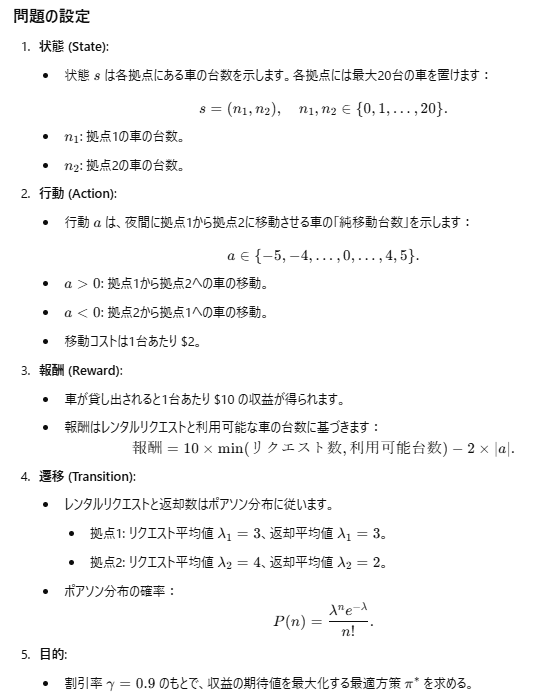

In [1]:
import numpy as np
from scipy.stats import poisson

In [2]:
MAX_CARS = 5
MAX_MOVE = 2
RENT_REWARD = 10
MOVE_COST = 2
DISCOUNT = 0.9


ポアソン分布は、単位時間内に発生する事象（レンタルリクエストや返却など）の回数をモデル化します。確率質量関数（PMF）は次のように表されます：

$$
P(N=n) = \frac{\lambda^n e^{-\lambda}}{n!}
$$
 

𝑁: ある時間内の事象の回数（ここではレンタルリクエスト数や返却数）。  
𝑛: 実際に発生した事象の数。  
𝜆: 平均発生回数（問題では 𝜆=3 や 𝜆=4など）。

In [3]:
# ポアソン分布の平均値
REQUEST_FIRST = 3
RETURN_FIRST = 3
REQUEST_SECOND = 4
RETURN_SECOND = 2

# ポアソン分布の確率を計算してキャッシュ
def poisson_prob(mean, n):
    return poisson.pmf(n, mean)

poisson_cache = {}
for mean in [REQUEST_FIRST, RETURN_FIRST, REQUEST_SECOND, RETURN_SECOND]:
    poisson_cache[mean] = [poisson_prob(mean, n) for n in range(MAX_CARS + 1)]

In [4]:
for key ,value in poisson_cache.items():
    print(key)
    print(value)
    print(len(value), sum(value))

3
[np.float64(0.049787068367863944), np.float64(0.14936120510359185), np.float64(0.22404180765538775), np.float64(0.22404180765538775), np.float64(0.16803135574154085), np.float64(0.10081881344492458)]
6 0.9160820579686967
4
[np.float64(0.01831563888873418), np.float64(0.07326255555493673), np.float64(0.14652511110987343), np.float64(0.19536681481316454), np.float64(0.19536681481316454), np.float64(0.1562934518505317)]
6 0.785130387030405
2
[np.float64(0.1353352832366127), np.float64(0.2706705664732254), np.float64(0.2706705664732254), np.float64(0.18044704431548356), np.float64(0.09022352215774178), np.float64(0.03608940886309672)]
6 0.9834363915193856


In [5]:
# 状態遷移と報酬を計算
def expected_return(state, action, value):
    rewards = 0
    state = list(state)

    # 移動コスト
    state[0] -= action
    state[1] += action
    rewards -= MOVE_COST * abs(action)

    # 移動後の状態を制限内に調整
    state[0] = min(state[0], MAX_CARS)
    state[1] = min(state[1], MAX_CARS)

    # レンタルリクエストと返却を計算
    total_return = 0.0
    for rent1 in range(MAX_CARS + 1):
        for rent2 in range(MAX_CARS + 1):
            prob_rent = poisson_cache[REQUEST_FIRST][rent1] * poisson_cache[REQUEST_SECOND][rent2]
            rental_reward = RENT_REWARD * (min(rent1, state[0]) + min(rent2, state[1]))
            remaining1 = state[0] - min(rent1, state[0])
            remaining2 = state[1] - min(rent2, state[1])

            for ret1 in range(MAX_CARS + 1):
                for ret2 in range(MAX_CARS + 1):
                    prob_return = poisson_cache[RETURN_FIRST][ret1] * poisson_cache[RETURN_SECOND][ret2]
                    new_cars1 = min(remaining1 + ret1, MAX_CARS)
                    new_cars2 = min(remaining2 + ret2, MAX_CARS)
                    prob = prob_rent * prob_return
                    total_return += prob * (rental_reward + DISCOUNT * value[new_cars1, new_cars2])
    return total_return


In [6]:
# 方策反復アルゴリズム
def policy_iteration():
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))  # 状態価値関数
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)  # 方策

    while True:
        # 方策評価
        while True:
            delta = 0
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    old_value = value[i, j]
                    action = policy[i, j]
                    value[i, j] = expected_return((i, j), action, value)
                    delta = max(delta, abs(old_value - value[i, j]))
            if delta < 1e-2:
                break

        # 方策改善
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in range(-MAX_MOVE, MAX_MOVE + 1):
                    if 0 <= i - action <= MAX_CARS and 0 <= j + action <= MAX_CARS:
                        action_returns.append(expected_return((i, j), action, value))
                    else:
                        action_returns.append(-np.inf)
                new_action = np.argmax(action_returns) - MAX_MOVE
                policy[i, j] = new_action
                if old_action != new_action:
                    policy_stable = False

        if policy_stable:
            return policy, value

# 実行
optimal_policy, optimal_value = policy_iteration()

# 結果の表示
print("最適方策:")
print(optimal_policy)

print("\n最適価値関数:")
print(optimal_value)

最適方策:
[[ 0  0 -1 -1 -2 -2]
 [ 1  0  0 -1 -1 -2]
 [ 1  1  0  0 -1 -1]
 [ 2  1  1  0  0 -1]
 [ 2  2  1  1  0  0]
 [ 2  2  2  1  1  0]]

最適価値関数:
[[36.96397586 43.35473533 49.61772866 55.6396263  61.21047376 66.44153568]
 [43.35487429 49.61787916 55.63984776 61.21074123 66.44183783 70.85263807]
 [49.61824604 55.64017791 61.21106815 66.44221312 70.85298737 74.89591472]
 [55.64065721 61.21142965 66.44256376 70.85331224 74.89625135 77.92626365]
 [61.21182002 66.44288998 70.85358147 74.89652496 77.92652231 80.56555348]
 [65.65661362 70.85382853 74.89677198 77.92685874 80.56589217 82.29322819]]
